# Tutorial

This short tutorial demonstrates how the Python features we outlined earlier are used in pysmo. This should be kept in mind particularly with regards to "type"; in most cases we are referring to the literal type data exist as inside Python.

## Plotting a Seismogram

In this first example we will download a sac file from IRIS and then write a function that generates a plot of it. First in a more conventional way, then using pysmo's protocol classes.

Pysmo has a class called `SAC`, which lets us use sac files directly in Python. We first import the `SAC` class from pysmo:

In [1]:
from pysmo import SAC

This let's us directly download data from IRIS and create a *sac-like* object.

In [2]:
mysac = SAC.from_iris(net="IU",
                      sta="ANMO",
                      cha="LHZ",
                      loc="00",
                      start="2005-03-28T15:00:00",
                      duration=3600*5,
                      scale="AUTO",
                      demean="true",
                      force_single_result=True)

Anyone familiar with the sac fileformat will know a sac file consists of a timeseries and there plenty of headers to store metadata in. For example:

In [3]:
print(mysac.delta, mysac.b, mysac.kzdate, ...)

1.0 9.999999747378752e-05 2005-03-28 Ellipsis


The traditional approach to using data stored in such a Python object would be to write a function that explicitly uses that exact object type is its input. So let's do that first, and then see how it compares to a solution using protocol classes. We begin by importing some modules we need:

In [4]:
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime, time, date, timedelta
%matplotlib inline

We can now get an idea of what it might look like by simply plotting the raw data:

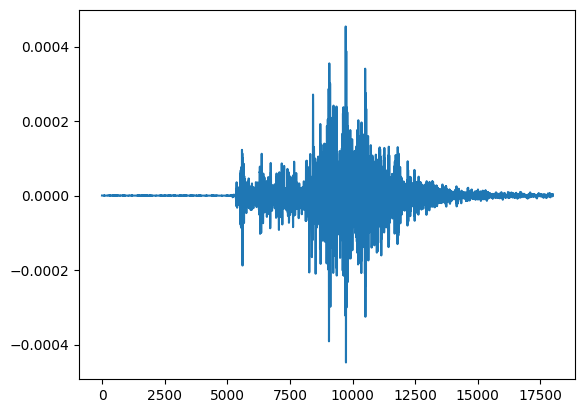

In [5]:
plt.plot(mysac.data)

However, a seismogram plot without a properly formatted X-axis is not very useful. Let's write a function for that (with type hints!):

In [6]:
def plotsac(sac: SAC) -> None:
    # First let's construct a datetime object of the begin time (and date):
    begin_time = time.fromisoformat(sac.kztime)
    begin_date = date.fromisoformat(sac.kzdate)
    begin_timedate = datetime.combine(begin_date, begin_time)
    
    # Because sac uses relative times, we must add sac.b
    begin_timedate += timedelta(sac.b)
    
    # We use a list comprehension to generate our times.
    # This could be solved more elegantly with pandas (if installed)
    t = [begin_timedate + timedelta(seconds=(sac.delta * i)) \
         for i, _ in enumerate(sac.data)]
    
    # Finally we can plot our sac object and format the x-axis:
    plt.plot(t, sac.data, 'r')
    plt.gcf().autofmt_xdate()

And we can call our function to generate the plot:

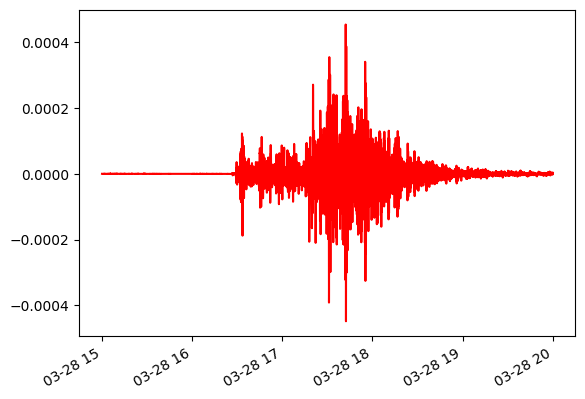

In [7]:
plotsac(mysac)

This wasn't too bad. Perhaps the time calculations were a bit tedious. Those calculations were also highly sac-specific, as the sac file format has different ways of specifying time in a seismogram.
Let's see how to solve this with the Seismogram protocol class in pysmo:

In [8]:
from pysmo import Seismogram

We can rewrite the `plotsac` function to use a `Seismogram` instead of a `SAC` object:

In [9]:
def plotseismo(seismo: Seismogram) -> None:
    # We can skip the time calculations
    t = [seismo.begin_time + timedelta(seconds=(seismo.sampling_rate * i)) for i, _ in enumerate(seismo.data)]
    plt.plot(t, seismo.data, 'g')
    plt.gcf().autofmt_xdate()

It looks pretty much the same, except for not having to calculate the begin time. Before we use it on our `SAC` object, we first verify that it is an instance of a `Seismogram`:

In [10]:
isinstance(mysac, SAC) # obviously true...

True

In [11]:
isinstance(mysac, Seismogram)

True

Cool, so we can go ahead and use our sac object with the `plotseismo` function:

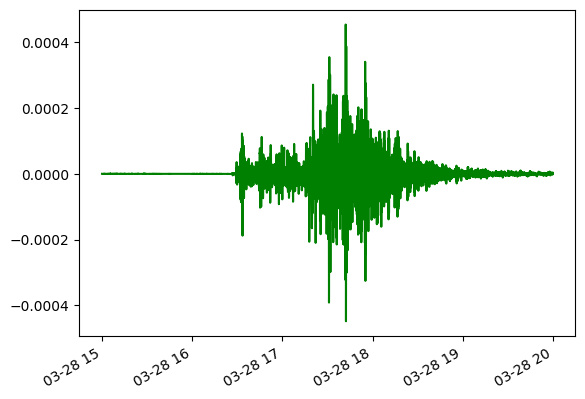

In [12]:
plotseismo(mysac)

So what is the significance of this example? At a first glance it would appear we did the same thing twice, just with a differently typed input. In a way that is true, except that there is a difference between the two types that does matter here. The `plotseismo` function explicitly requires a `SAC` object as input, whereas the `plotseismo` function only requires an object to be a subtype of `Seismogram`. It doesn't need to *be* a `Seismogram`, it merely needs to *speak* `Seismogram`, so to speak.

Imagine a scenario where you write hundreds of functions that use a `SAC` object as input, and then suddenly the `SAC` format changes. You now have to edit all your functions to adapt to that change. Similarly, if you want to support another (potentially wildly different) input format you may well need to start from scratch.

## Calculating Great Circle Distance

The initial idea for pysmo stems from the fact that the different file formats used in seismology appear more suitable to archiving data rather than writing code to process these data. What we mean by that is the huge discrepancy between the amount of (meta)data stored in the files and what is actually needed to solve a particular problem. The sac file format specifies about 130 header variables, and in the example above we wrote a function that only uses four of them!

Key for pysmo is that a type of data should not refer to an abstract construct of how data are organised inside a file, but rather to something that exists in the physical world. Pysmo's type definitions are thus quite specific (and narrowly defined).

In this second example we calculate the distance between a station and an event. We skip the "traditional" approach here and go straight to a function that uses pysmo's protocol classes.

In [13]:
from pysmo import Station, Epicenter
from pyproj import Geod

We want to use our `mysac` object from before, so let's check if it is a subtype of `Station` and `Epicenter`:

In [14]:
print(isinstance(mysac, Station),isinstance(mysac, Epicenter))

True True


Before proceeding, we must add the actual coordinates to `mysac` (the are not included in the downloaded file):

In [15]:
mysac.station_latitude, mysac.station_longitude = 34.9462, 106.4567
mysac.event_latitude, mysac.event_longitude = 2.09, -97.15

Excellent, now we can write our function:

In [16]:
def gcdist(station: Station, event: Epicenter) -> float:
    """Return the distance using WGS84"""
    g = Geod(ellps="WGS84")
    # The g.inv method returns azimuth, back-azimuth and distance (in metres)
    # We only need the distance here:
    _, _, dist = g.inv(event.event_longitude, event.event_latitude,
                          station.station_longitude, station.station_latitude)
    return dist / 1000

And calculate the distance:

In [17]:
gcdist(mysac, mysac)

15228.93484528352

Note how we pass `mysac` to the function twice, first as a station and then as an Epicenter. That is because the function is again not written for a single object that contains all the information we might need (and more!). Instead we pass narrowly defined types of data to the function, that could easily be stored in two separate places.